# 實作Adagrad

http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Gradient%20Descent%20(v2).pdf#page=6
http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/DNN%20tip.pdf#page=20

- Adagrad的精神
- 每個參數都給他不同的learning rate，用learning rate去除過去所有gradient的平方合開根號
- 過去所有gradient的平方合開根號推估二次微分結果，為什麼不直接算二次微分，因為很慢會瘋掉
- w1在這個方向上，gradient都比較小，代表它比較平坦，就給它比較大的learning rate
- w2在這個方向上，gradient都比較大，代表它比較陡峭，就給它比較小的learning rate
- 但實際上呢，我們面對的問題可能比Adagrad可以處理的問題更加複雜
- 之前在做regression或logistic的時候，loss function都是長得像是convex形狀
- 但是當我們在做deep learning的時候，loss function可以是任何形狀
- 譬如說它可以是一個怪異的月形形狀，如果你今天遇到這個error surface，就算在同一個方向上，你的learning rate也能夠快速地變動
- 在剛剛那個convex上，這個方向很平坦就一直很平坦，這個方向很陡峭就一直很陡峭
- 但是今天在更複雜的問題上，同一個方向上，在某個區域很平坦，但是忽然在某個區域又很陡峭
- 真正要處理deep learning的問題，用Adagrad可能是不夠的
- 你需要更dynamic的調整learning rate的方法
- 這邊有一個Adagrad的進階版，叫做RMSProp (之後整理)


In [44]:
%pylab inline
import theano
import theano.tensor as T
import itertools as it
import time

Populating the interactive namespace from numpy and matplotlib


## 把numpy array type 定義成 theano.config.floatX
### <span style='color:red'>在theano的世界裡，請記得都要轉成floatX</span>

In [45]:
def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

In [46]:
### make batches
def mk_batches(x_data, y_data, batch_size, shuffle=False):
    x_batch = list()
    y_batch = list()
    
    x_data_size = x_data.shape[0]
    y_data_size = y_data.shape[0]
    assert x_data_size == y_data_size , 'the x, y dimension is error'
    
    if shuffle:
        indices = np.arange(x_data_size)
        np.random.shuffle(indices)
    
    #range(start, stop, step)
    for start_idx in range(0, x_data_size, batch_size):
        if shuffle:
            idx = indices[start_idx : start_idx + batch_size]            
        else:
            idx = slice(start_idx, start_idx + batch_size)
            
        x_batch.append(x_data[idx])
        y_batch.append(y_data[idx])
    
    return x_batch, y_batch

In [47]:
### data
batch_size = 10
x_data = floatX(np.loadtxt('.\ex2x.dat'))
y_data = floatX(np.loadtxt('.\ex2y.dat'))

In [48]:
### params / init weights
w = theano.shared(floatX(-1.))
b = theano.shared(floatX(-1.))

In [49]:
### model
x = T.vector()
y = w*x + b

In [50]:
### cost/error/loss
y_hat = T.vector()
cost = T.mean((y-y_hat)**2)

## sgd

In [51]:
def gd(params, grads, lr):
    updates = []
        
    for p, g in it.izip(params, grads):
        updates.append([p, p - lr*g])

    return updates

## adagrad
* 這裡為什麼不用for loop寫update function?
* 因為我不知道grads的微分結果要怎麼取出來，所以只好先在外面算一算存在list中 (second_dw)，等於又多算了一次微分 (所以後面training速度慢???)
* 記得second_dw也是theano variable

* <span style='color:red'>update是expression</sapn>

In [52]:
def Adagd(params, grads):
    updates = []
    lr = floatX(1.0)
    
    updates.append([params[0], params[0] - (lr/second_dw)*grads[0]])
    
    updates.append([params[1], params[1] - (lr/second_db)*grads[1]])
    
    return updates

## 取gradient

In [53]:
dw, db = T.grad(cost, [w, b])

## 把每一次的微分值都存起來，然後計算類二次微分
![alt tag](https://github.com/JiaMauJian/gradient-descent/blob/master/nb_img/adagrad.png?raw=true)

In [54]:
his_grad_dw = []
his_grad_db = []
second_dw = theano.shared(floatX(0.))
second_db = theano.shared(floatX(0.))
def calc_second_derivative(x, y):
    g_dw = f_grad_dw(x, y)          
    g_db = f_grad_db(x, y) 
    his_grad_dw.append(g_dw)
    his_grad_db.append(g_db)
    second_dw.set_value(floatX(np.sqrt(np.sum(np.square(his_grad_dw)))))
    second_db.set_value(floatX(np.sqrt(np.sum(np.square(his_grad_db)))))

## 整理theano function

In [55]:
### theano function
f_model = theano.function([x], y)

f_cost = theano.function([x, y_hat], cost)

f_grad_dw = theano.function([x, y_hat], dw)

f_grad_db = theano.function([x, y_hat], db)

f_train = theano.function(inputs=[x, y_hat],
                          outputs=[cost, w, b],
                          updates=gd([w, b], [dw, db], 0.01))

f_train_adagd = theano.function(inputs=[x, y_hat],
                                outputs=[cost, w, b],
                                updates=Adagd([w, b], [dw, db]))

## 跑

In [56]:
epochs = 1000

## sgd training 結果

In [57]:
his_cost_by_gd = []
tStart = time.time()
for t in range(epochs):
        all_cost = 0       
        x_batches, y_batches = mk_batches(x_data, y_data, batch_size, True)        
        batch_num = len(x_batches)      
            
        for i in range(batch_num):            
            tr_cost, tr_w, tr_b= f_train(x_batches[i], y_batches[i])            
            all_cost += tr_cost            
            
        his_cost_by_gd.append(all_cost/batch_num)        
        #print 'batch avg cost=%f' % (all_cost/batch_num)        
tEnd = time.time()
print '(sgd) w=%f, b=%f' % (tr_w, tr_b)
print 'Loss = %f' % (his_cost_by_gd[-1])
print 'It costs %f sec' % (tEnd-tStart)

(sgd) w=0.063021, b=0.750077
Loss = 0.002105
It costs 0.106000 sec


## adagrad training 結果

In [58]:
# reset weights
w.set_value(floatX(-1.))
b.set_value(floatX(-1.))

his_cost_by_adagd = []
tStart = time.time()
for t in range(epochs):
        all_cost = 0       
        x_batches, y_batches = mk_batches(x_data, y_data, batch_size, True)        
        batch_num = len(x_batches)      
            
        for i in range(batch_num):
            calc_second_derivative(x_batches[i], y_batches[i])            
            tr_cost, tr_w, tr_b= f_train_adagd(x_batches[i], y_batches[i])            
            all_cost += tr_cost            
            
        his_cost_by_adagd.append(all_cost/batch_num)        
        #print 'batch avg cost=%f' % (all_cost/batch_num)        
tEnd = time.time()
print '(Adagd) w=%f, b=%f' % (tr_w, tr_b)
print 'Loss = %f' % (his_cost_by_adagd[-1])
print 'It costs %f sec' % (tEnd-tStart)

(Adagd) w=0.064130, b=0.750053
Loss = 0.002010
It costs 1.993000 sec


## 最佳解

In [59]:
print '(closed-fom) w=0.0639, b= 0.7502'

(closed-fom) w=0.0639, b= 0.7502


## 畫圖比一比

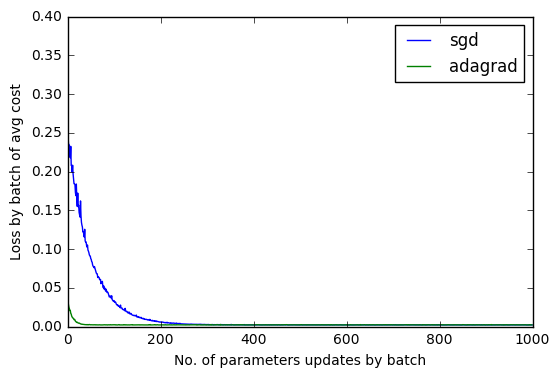

In [60]:
### cost chart
plt.plot(his_cost_by_gd, label='sgd')
plt.plot(his_cost_by_adagd, label='adagrad')
plt.legend()
plt.ylim([0, 0.4])
plt.xlabel("No. of parameters updates by batch")
plt.ylabel("Loss by batch of avg cost")
plt.show()

## (Adagrad) 當epoch越大時，training會跑越久，我猜是因為需要計算過去所有gradient的平方合開根號，去推估二次微分